In [1]:
import shutup
shutup.please()

In [2]:
import itertools
import numpy as np

from src.agents.agent import Agent
from src.environments.discrete.mountain_car import environment

### Dev notes:
* Agent handles:
    * Load the environment and it's related variables
    * Starts the running_reward
    * Validates learn fn and learn condition
    * Test fn
    * Decrement epsilon fn
    * Plot learning results

In [5]:
class QAgent(Agent):
    def __init__(self, 
                environment, 
                alpha = 0.1,
                gamma = 0.99,
                epsilon=1.0,
                epsilon_min=0.01,
                epsilon_decay=0.0001,
                bucket_size=20):
        
        super(QAgent, self).__init__(
            environment,
            epsilon=epsilon,
            epsilon_min=epsilon_min,
            epsilon_decay=epsilon_decay)
        
        # Args
        self.bucket_size = bucket_size
        self.alpha = alpha
        self.gamma = gamma

        # Boot
        self.__init_buckets()
        self.__init_q()


    def __init_buckets(self):

        individual_observations = self.observation_shape[0]
        self.buckets = []
        # in the MountainCar case, pos_space, vel_space 
        for i in range(individual_observations):
            self.buckets.append(
                np.linspace(
                    self.env.observation_space.low[i],
                    self.env.observation_space.high[i],
                    self.bucket_size
                )
            )
        
    def __init_q(self):
        Q = {}
        states = []
        
        bucket_indices = []
        for bucket in self.buckets:
            bucket_indices.append(range(len(bucket)+1))
            
        for b in itertools.product(*bucket_indices):
            states.append(b)
        
        for state in states:
            for action in [0,1,2]:
                Q[state,action] = 0
                
        self.Q = Q

        

    def get_state(self,observation):
        #pos,vel = observation
        state = []
        for i in range(len(self.buckets)):
            state.append(np.digitize(observation[i],self.buckets[i]))

        return tuple(state)

    def choose_action(self, state):
        values = np.array([self.Q[state,a] for a in self.actions])
        action = np.argmax(values)
        
        return action
    
    def learn(self, timesteps=-1, plot_results=True, reset=False, log_each_n_episodes=100, success_threshold=False):
        
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold    
        
        obs = self.env.reset()
        state = self.get_state(obs)

        score = 0
        timestep = 0
        episode = 0

        while self.learning_condition(timesteps,timestep):
            
            # Choose action
            action = np.random.choice(self.actions) if np.random.random() < self.epsilon else self.choose_action(state)
            
            # Step
            obs_,reward,done, info = self.env.step(action)
            
            # Get next state
            score += reward
            state_ = self.get_state(obs_)
            action_ = self.choose_action(state_)

            # Update Q table
            self.Q[state,action] = self.Q[state,action] + self.alpha*(reward + self.gamma*self.Q[state_,action_] - self.Q[state,action])
            
            # Set state as next state so the agent keeps 
            state = state_
            
            if done:

                # Loop episode state
                if episode % log_each_n_episodes == 0 and episode > 0:
                    print('episode {}, running reward: {:.2f}, epsilon: {:.3f}'.format(episode,self.running_reward.reward,self.epsilon))
                
                # Update pointers
                self.decrement_epsilon()
                self.running_reward.step(score)
                
                # Break loop if average reward is greater than success threshold
                if self.did_finnish_learning(success_threshold,episode):
                    break
                
                # Reset environment
                score = 0
                episode +=1
                obs = self.env.reset()
                state = self.get_state(obs)
                
            # Update timestep counter
            timestep+=1
        
        if plot_results:
            self.plot_learning_results()
    


| ---------------------------------
| MountainCar-v0
| 
| Action space: Discrete with low state-space
| Environment beated threshold: -150
| Dev notes:
|   * Switched _max_episode_steps from 200 to 1000 so 
|     the agent can explore better.
| ----------------------------------------------------------   


episode 1000, running reward: -995.24, epsilon: 0.900
episode 2000, running reward: -891.13, epsilon: 0.800
episode 3000, running reward: -642.26, epsilon: 0.700
episode 4000, running reward: -377.17, epsilon: 0.600
episode 5000, running reward: -326.60, epsilon: 0.500
episode 6000, running reward: -255.68, epsilon: 0.400
episode 7000, running reward: -244.40, epsilon: 0.300
episode 8000, running reward: -196.55, epsilon: 0.200
episode 9000, running reward: -168.02, epsilon: 0.100
Agent solved environment at the episode 9430


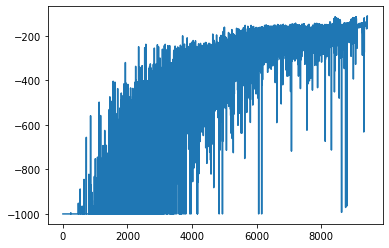

In [6]:
agent = QAgent(environment)
agent.learn(log_each_n_episodes=1000)

In [ ]:
agent.test()